In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2024-07-09 16:45:06.412300: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-09 16:45:07.052996: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-09 16:45:07.056106: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 16:45:08.355039: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DATASET_PATH = '/home/shreyasidabache/Documents/Word_data/data'

data_dir = pathlib.Path(DATASET_PATH)
# if not data_dir.exists():
#   tf.keras.utils.get_file(
#       'mini_speech_commands.zip',
#       origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
#       extract=True,
#       cache_dir='.', cache_subdir='data')

In [3]:
# List commands
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['up' 'right' 'help' 'backward' 'down' 'forward' 'yes' 'go' 'no' 'left'
 'stop']


In [4]:
# Get file names
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 11000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'/home/shreyasidabache/Documents/Word_data/data/help/Voice 055.wav', shape=(), dtype=string)


In [5]:
# Split dataset
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

In [6]:
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))


Training set size 6400
Validation set size 800
Test set size 800


In [7]:
# Define functions for audio processing
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(input=file_path, sep=os.path.sep)
    return parts[-2]

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [8]:
# Create dataset
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)


In [9]:
# Define function to get spectrogram
def get_spectrogram(waveform):
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [10]:
# Function to get spectrogram and label id
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.math.argmax(label == commands)
    return spectrogram, label_id

In [11]:
# Create spectrogram dataset
spectrogram_ds = waveform_ds.map(map_func=get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)


In [12]:
# Preprocess dataset function
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(map_func=get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
    return output_ds

# Prepare datasets
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [13]:
# Set batch size and prepare datasets
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [18]:
# Get input shape and number of labels
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

Input shape: (124, 129, 1)


In [19]:
# Define and compile the model
def build_model(input_shape, num_labels):
    norm_layer = layers.Normalization()
    norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Resizing(64, 64),
        norm_layer,
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(256, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels),
        layers.Softmax()
    ])
    return model

model = build_model(input_shape, num_labels)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 1)         0         
                                                                 
 normalization (Normalizati  (None, 64, 64, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [21]:
# Train the model
EPOCHS = 50
callbacks = [
    tf.keras.callbacks.EarlyStopping(verbose=1, patience=15),
    tf.keras.callbacks.ModelCheckpoint("/home/shreyasidabache/Downloads/Word_data/checkpoints1/model_{epoch:02d}.h5",
                                       save_best_only=True,
                                       monitor="val_accuracy",
                                       save_freq="epoch",
                                       verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6, verbose=1),
]


In [22]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/50


/home/shreyasidabache/.local/lib/python3.8/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-07-09 16:49:25.811879: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2024-07-09 16:49:25.936612: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2024-07-09 16:49:25.945303: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2024-07-09 16:49:26.015287: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2024-07-09 16:49:26.110985: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free syst

100/100 [==============================] - ETA: 0s - loss: 2.3673 - accuracy: 0.0967
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to /home/shreyasidabache/Downloads/Word_data/checkpoints1/model_01.h5
100/100 [==============================] - 68s 666ms/step - loss: 2.3673 - accuracy: 0.0967 - val_loss: 2.3385 - val_accuracy: 0.1250 - lr: 1.0000e-04
Epoch 2/50


/home/shreyasidabache/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - ETA: 0s - loss: 2.2914 - accuracy: 0.1934
Epoch 2: val_accuracy improved from 0.12500 to 0.24875, saving model to /home/shreyasidabache/Downloads/Word_data/checkpoints1/model_02.h5
100/100 [==============================] - 69s 689ms/step - loss: 2.2914 - accuracy: 0.1934 - val_loss: 2.2122 - val_accuracy: 0.2488 - lr: 1.0000e-04
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 2.1819 - accuracy: 0.2419
Epoch 3: val_accuracy improved from 0.24875 to 0.27625, saving model to /home/shreyasidabache/Downloads/Word_data/checkpoints1/model_03.h5
100/100 [==============================] - 70s 702ms/step - loss: 2.1819 - accuracy: 0.2419 - val_loss: 2.0982 - val_accuracy: 0.2763 - lr: 1.0000e-04
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 2.0867 - accuracy: 0.2761
Epoch 4: val_accuracy improved from 0.27625 to 0.30125, saving model to /home/shreyasidabache/Downloads/Word_data/checkpoints1/model_04.h5
100/

In [24]:
model.load_weights("/home/shreyasidabache/Downloads/Word_data/checkpoints1/model_48.h5")

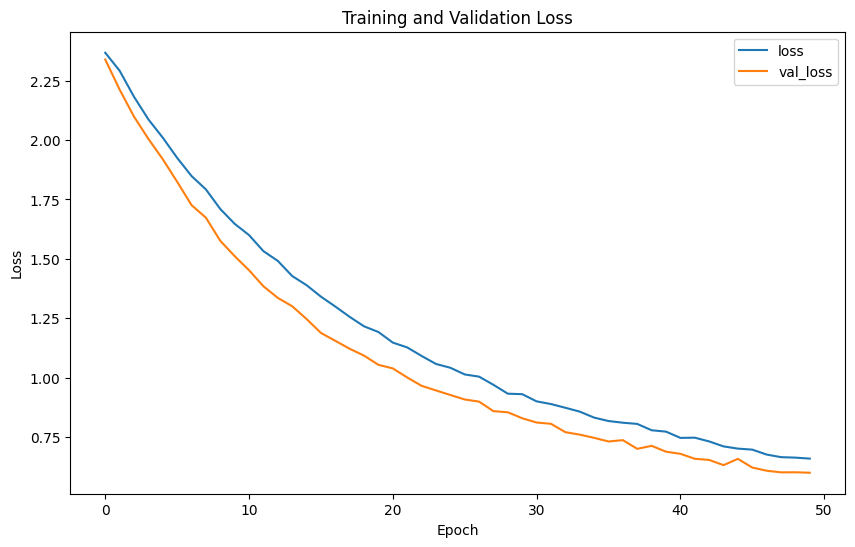

In [25]:
# Plot training history
metrics = history.history
plt.figure(figsize=(10, 6))
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [26]:
# Evaluate on test set
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.2%}')

25/25 [==============================] - 2s 70ms/step
Test set accuracy: 83.38%


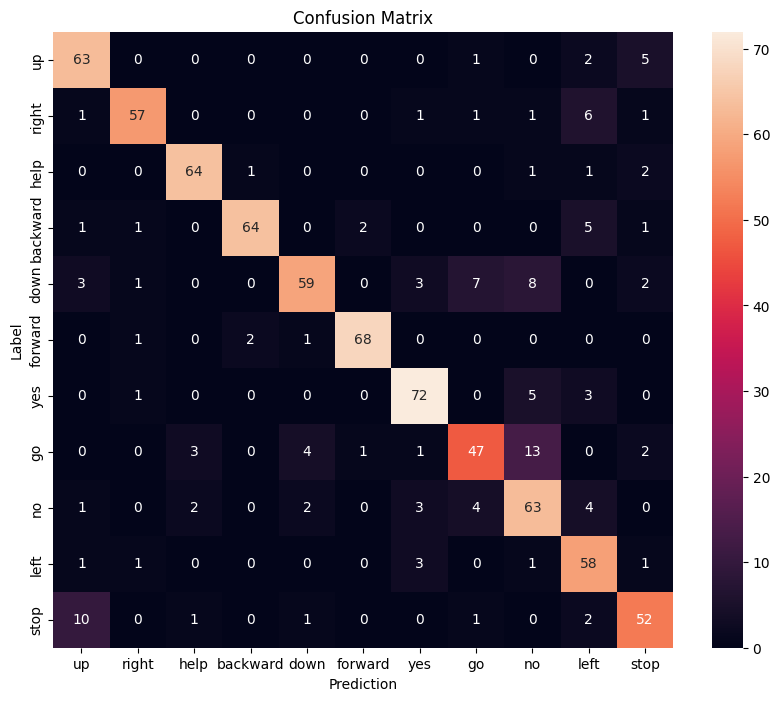

In [27]:
# Plot confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Confusion Matrix')
plt.show()

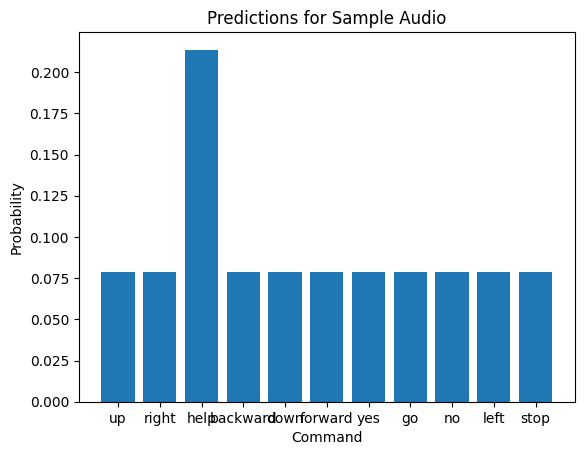

In [28]:
# Make predictions on a sample file
sample_file = "/home/shreyasidabache/Documents/Word_data/data/help/help75.wav"
sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title('Predictions for Sample Audio')
    plt.xlabel('Command')
    plt.ylabel('Probability')
    plt.show()

In [29]:
import tensorflow as tf

# Load the Keras model
model = tf.keras.models.load_model('/home/shreyasidabache/Downloads/Word_data/checkpoints1/model_48.h5')

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.allow_custom_ops = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpsk7dsxdz/assets


INFO:tensorflow:Assets written to: /tmp/tmpsk7dsxdz/assets
2024-07-09 17:54:13.536005: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-07-09 17:54:13.536064: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-07-09 17:54:13.552737: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsk7dsxdz
2024-07-09 17:54:13.554820: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-07-09 17:54:13.554835: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpsk7dsxdz
2024-07-09 17:54:13.561852: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-07-09 17:54:13.563908: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-07-09 17:54:13.627332: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio